Transformación no lineal de variables (independientes y dependiente) --- 12:09 min
===

* 12:09 min | Ultima modificación: Marzo 30, 2021 | [YouTube](https://youtu.be/Yvzmuf1vlWY)

A continuación, se describen las principales transformaciones que pueden realizarse tanto a la variable dependiente como independiente.

* Logaritmo (natural):

$$
w = \log (z)
$$

* Logaritmo base 10:

$$
w = \log_{10} (z)
$$

* Logística:
$$
w = \log 
\left[
\frac{c \cdot z}{1 - c \cdot z}
\right]
$$

con:

$$
c = (1 - 10^{-6}) \cdot 10 ^{-\text{ceil} (\log_{10} (\max (z)))}
$$

donde la función ceil() retorna el entero más pequeño que es igual o mayor que $z$.

* Raíz cuadrada:
$$
w = z^{1/2}
$$

* Raíz cúbica:
$$
w = z^{1/3}
$$

* Box-Cox:
$$
w = 
\begin{cases}
\frac{z^\lambda - 1}{\lambda}, & \lambda \ne 0 \\
\\
\log{z}, & \lambda = 0
\end{cases}
$$

## Comparación de modelos con diferentes transformaciones de las variables independientes

En este caso, se comparan diferentes modelos alternativos que difieren en la transformación aplicada a las variables independientes. Se selecciona el modelo con mejor ajuste a las muestras de entrenamiento y prueba.

## Comparación de modelos con diferentes transformaciones de la variable dependiente

En este caso, los modelos no pueden compararse directamente con la serie transformada.

**Pregunta.---** ¿Explique por qué no se pueden comparar?

El procedimiento es el siguiente:

* Se aplica la transformación seleccionada a la variable dependiente.

* Se construye el mejor modelo posible.

* Se pronostican los datos de entrenamiento y prueba.

* Se aplica la transformación inversa a los pronosticos de entrenamiento y prueba.

* Se calcula la función de pérdida para los pronósticos con la transformación inversa.


Una vez se ha calculado la función de pérdida para todas las transformaciones se selecciona la que genera mejores resultados.

## Ejemplo

In [1]:
import math

import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
#
# Proceso generador de datos
#
def f(x):
    y = [math.exp(0.15 * u + 1) if u < 5 else math.exp(0.25 * u + 1) for u in x]
    return np.array(y)

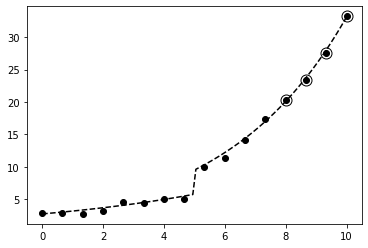

In [3]:
#
# Generación de la muestra de datos
#
np.random.seed(123456)
index = list(range(12))

x_real = np.linspace(start=0, stop=10, num=100)
x_data = np.linspace(start=0, stop=10, num=16)
x_fit = x_data[index]
x_test = np.delete(x_data, index)

d_orig_real = f(x_real)
d_orig_data = f(x_data) + np.random.normal(0, 0.4, len(x_data))
d_orig_fit = d_orig_data[index]
d_orig_test = np.delete(d_orig_data, index)

# muestra usada para evaluar la generalización
plt.plot(x_data, d_orig_data, "o", color="black")
plt.plot(x_real, d_orig_real, "--", color="black")
plt.plot(x_test, d_orig_test, "o", color="black", fillstyle="none", markersize=11)
plt.show()

## Transformación de Box-Cox

In [4]:
def boxcox(z, Lambda):
    if Lambda == 0:
        return np.log(z)
    return (np.power(z, Lambda) - 1.0) / Lambda


#
# Función inversa de Box-Cox
#
def boxcox_inv(z, Lambda):
    if Lambda == 0:
        return np.exp(z)
    return np.power(Lambda * z + 1, 1.0 / Lambda)

## Modelo de regresión

$$y_p = g(x_p) = w_0 + w_1 x_p$$

## Función de pérdida

$$\text{SSE}(w) = \sum_p [d_p - g(x_p)]^2 $$

In [5]:
def SSE(observed, forecast):

    forecast_fit = forecast[index]
    forecast_test = np.delete(forecast, index)

    observed_fit = observed[index]
    observed_test = np.delete(observed, index)

    SSE_fit = sum(np.power(observed_fit - forecast_fit, 2))
    SSE_test = sum(np.power(observed_test - forecast_test, 2))

    return SSE_fit, SSE_test

## Gradiente de la función de pérdida

$$
\begin{split}
  \frac{\partial}{\partial \mathbf{w}}\text{SSE}(\mathbf{w}) 
    & = \sum_p -2 \cdot [d_p - g(x_p)] \cdot \frac{\partial}{\partial \mathbf{w}} g(x_p) \\ \\
    & = -2 \sum_p e_p \cdot \frac{\partial}{\partial \mathbf{w}} g(x_p)
\end{split}
$$

$$
\frac{\partial}{\partial \mathbf{w}} g(x_p) = \frac{\partial}{\partial \mathbf{w}} \left( 
w_0 + w_1 * x_p
\right) = 
\left[
\begin{matrix}
 1 \\ 
 x_p
\end{matrix}
\right]
$$

In [6]:
def gSSE(observed, forecast):

    forecast_fit = forecast[index]
    forecast_test = np.delete(forecast, index)

    observed_fit = observed[index]
    observed_test = np.delete(observed, index)

    e_fit = observed_fit - forecast_fit

    grd = [[1, u] for u in x_data]
    grd = [u for i, u in enumerate(grd) if i in index]
    grd = [[-2.0 * e_fit[i] * u for u in g] for i, g in enumerate(grd)]
    grd = [[g[icol] for g in grd] for icol in range(len(w))]
    grd = [sum(u) for u in grd]

    return grd

## Gradiente descendente

$$ \mathbf{w}_k = \mathbf{w}_{k-1} - \mu \frac{\partial}{\partial \mathbf{w}} \text{SSE}(\mathbf{w}_{k-1})$$

In [7]:
def mejora(w, mu, observed, forecast):
    grd = gSSE(observed, forecast)
    w = [u - mu * g for u, g in zip(w, grd)]
    return w

## Early Stopping

Lambda   SSE
--------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in power
  del sys.path[0]


 -0.990  455.35718
 -0.965  448.17079
 -0.940  440.87867
 -0.915  433.06143
 -0.890  425.14793
 -0.865  416.93121
 -0.841  408.19681
 -0.816  399.39521
 -0.791  390.31902
 -0.766  380.75698
 -0.741  370.95080
 -0.716  360.92171
 -0.691  350.46700
 -0.666  339.84124
 -0.641  329.07482
 -0.616  317.97725
 -0.592  306.58984
 -0.567  294.95858
 -0.542  283.13375
 -0.517  271.16922
 -0.492  258.91714
 -0.467  246.65164
 -0.442  234.43375
 -0.417  221.95211
 -0.392  209.48799
 -0.367  197.12342
 -0.343  184.77608
 -0.318  172.54816
 -0.293  160.53803
 -0.268  148.56815
 -0.243  136.90490
 -0.218  125.53540
 -0.193  114.47293
 -0.168  103.75411
 -0.143   93.43485
 -0.118   83.66107
 -0.094   74.28272
 -0.069   65.54861
 -0.044   57.33327
 -0.019   49.74846
  0.006   42.83310
  0.031   36.60638
  0.056   31.08019
  0.081   26.28173
  0.106   22.25844
  0.131   19.00937
  0.155   16.56770
  0.180   14.93968
  0.205   14.34356
  0.230   14.344


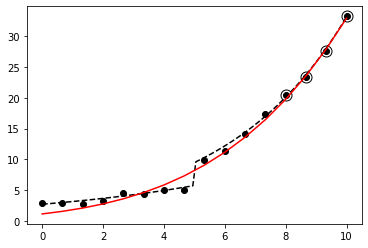

In [8]:
w_opt = None
Lambda_opt = None
y_orig_opt = None
SSE_orig_opt = None


print('Lambda   SSE')
print('--------------------------')

for Lambda in np.linspace(start=-0.99, stop=1.5, num=101):

    # Transforma la variable de salida
    d_transf_data = boxcox(d_orig_data, Lambda)

    # tasa de aprendizaje
    alpha = 0.000001

    #
    # Coeficientes iniciales. La salida es cero
    # por ser un modelo lineal
    #
    w = np.array([0.0, 0.0])
    y_transf_opt = np.array([0] * len(d_orig_data))

    #
    # Solo para el proceso de entrenamiento
    #
    SSE_transf_test_previous = None

    for epoch in range(10000):

        y_transf_data = w[0] + w[1] * x_data
        w = mejora(w, alpha, d_transf_data, y_transf_data)
        SSE_transf_fit, SSE_transf_test = SSE(d_transf_data, y_transf_data)

        if (
            SSE_transf_test_previous is None
            or SSE_transf_test_previous > SSE_transf_test
        ):
            SSE_transf_test_previous = SSE_transf_test
            y_transf_opt = y_transf_data
        else:
            # aumenta el error de prueba
            break

    y_orig_data = boxcox_inv(y_transf_opt, Lambda)
    SSE_orig_fit, _ = SSE(d_orig_data, y_orig_data)

    if SSE_orig_opt is None or SSE_orig_fit < SSE_orig_opt:
        y_orig_opt = y_orig_data
        SSE_orig_opt = SSE_orig_fit
        Lambda_opt = Lambda
        print("{:7.3f}  {:9.5f}".format(Lambda, SSE_orig_opt))
    else:
        break

print("{:7.3f}  {:7.3f}".format(Lambda, SSE_orig_opt))
plt.plot(x_data, d_orig_data, "o", color="black")
plt.plot(x_real, d_orig_real, "--", color="black")
plt.plot(x_test, d_orig_test, "o", color="black", fillstyle="none", markersize=11)
plt.plot(x_data, y_orig_opt, "-", color="red")
plt.show()

In [9]:
print("   Obs.     Pron.")
print("------------------")
for a, b in zip(d_orig_data, y_orig_opt):
    print("{:7.3f}   {:7.3f}".format(a, b))

   Obs.     Pron.
------------------
  2.906     1.147
  2.891     1.567
  2.716     2.101
  3.215     2.770
  4.540     3.598
  4.412     4.611
  5.001     5.840
  5.056     7.316
  9.968     9.074
 11.341    11.152
 14.194    13.592
 17.431    16.438
 20.374    19.739
 23.446    23.547
 27.616    27.916
 33.224    32.906
